# FITS binary table in Python

We will be going through how to manipulate fits table with Python. We will be using ```astropy.table.Table```.

### Reading and displaying a table

In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit as cf
import scipy.signal as signal
from astropy.timeseries import LombScargle
import astropy.units as u
import matplotlib.ticker as ticker
%xmode Plain

def initPlot(mn, labels, lim, figSize=(16, 9), share=('none', 'none'),
        spkw=None, gskw=None):
    '''
    Initialize a plot with both axis label and tick shown

    Parameters
    ----------
    mn: 2-tuple, (number of rows, number of columns)
    labels: list of 2-tuple str, string for x and y axis. Allow latex.
    lim: list of 2-tuple, limit for x and y axis.
    figSize: 2-tuple, default (16, 9). Size of the figure in inch. DPI is fixed
             at 300.
    share: 2-tuple, default ('none', 'none'). Whether to share x or y axis.
    spkw: dict, keywords to pass to add_subplot
    gskw: dict, keywords to pass to GridSpec

    Returns
    -------
    fig: matplotlib.pyplot.Figure, the figure itself
    ax: matplotlib.pyplot.axes, the axes in 2D array
    '''
    # Set up the Figure and axes
    fig, ax = plt.subplots(nrows=mn[0], ncols=mn[1], sharex=share[0],
            sharey=share[1], squeeze=False, subplot_kw=spkw, gridspec_kw=gskw,
            figsize=figSize, dpi=300)
    # Set up the limit and labels for each axes
    for i in range(mn[0]):
        for j in range(mn[1]):
            num = i * mn[1] + j
            ax[i][j].set_xlabel(labels[num][0], fontsize=24)
            ax[i][j].set_xlim(lim[num][0])
            ax[i][j].set_ylabel(labels[num][1], fontsize=24)
            ax[i][j].set_ylim(lim[num][1])
            ax[i][j].tick_params(axis='both', which='major', labelsize=20)
    return fig, ax


phot_data = Table.read('./rr_lyr_M3_V.fits')
#phot_data.show_in_notebook()

Exception reporting mode: Plain


### Accessing and modifying columns

Each column must have a name. So similar to dictionary in native Python, we can access a column by its name, and if the name does not exist, a new one with the given name will be created.

The entire table could also be sorted by one column.

In [2]:
# Calculate the magnitude offset and save it in column 'mag_offset'
phot_data['mag_offset'] = (15.74 + 15.70 + 15.05 + 15.99 - phot_data['mag_ins'][:, 4] - phot_data['mag_ins'][:, 5] - phot_data['mag_ins'][:, 6] - phot_data['mag_ins'][:, 7]) / 4.0
# Convert to apparent magnitude and save it in column 'mag_app'
phot_data['mag_app'] = phot_data['mag_ins'] + phot_data['mag_offset'][:, np.newaxis]
# Sort the table by column 'jd'
phot_data.sort('jd')
phot_data.show_in_notebook()

idx,aperture_sum [8],aperture_sum_err [8],x_image [8],y_image [8],bg_median [8],aperture_sum_bgsub [8],aperture_sum_bgsub_err [8],mag_ins [8],mag_ins_err [8],jd,mag_offset,mag_app [8]
0,62904.237095577606 .. 65146.95565574088,285.1571093494175 .. 289.06278806320927,812.7342403926078 .. 1504.5746848198721,2017.693871235582 .. 872.4991036542737,98.34225845336914 .. 100.17003631591797,32009.105426124283 .. 33677.61063574981,334.97717635977676 .. 339.15577610128787,-11.263183842192044 .. -11.318353178823834,0.011362293425564678 .. 0.010934080482987676,2459294.6588767767,27.260135499709712,15.996951657517668 .. 15.941782320885878
1,61336.17466062572 .. 63508.14314562357,282.394253284043 .. 286.21405108581337,812.5822423666563 .. 1503.7646818644002,2016.572342734654 .. 871.3840155737121,95.11776733398438 .. 96.26534271240234,31454.04675239487 .. 33265.49379956488,331.1021627777189 .. 334.9046616352351,-11.244191319936093 .. -11.304984936457611,0.011429041497629168 .. 0.010930789678654998,2459294.6625226075,27.256063667244764,16.01187234730867 .. 15.951078730787152
2,61006.800672404235 .. 63273.87255131388,281.8104692303163 .. 285.80450071551235,816.0293105950002 .. 1507.774424631753,2014.6672162109483 .. 870.0531387123716,92.29615020751953 .. 93.08376693725586,32011.109927747893 .. 34030.74471345913,329.26103825455476 .. 333.0575632936416,-11.263251831966022 .. -11.32967863276061,0.011167704926699253 .. 0.010626057636446945,2459294.666168438,27.266119094577387,16.002867262611367 .. 15.936440461816778
3,59970.866660937834 .. 62775.866445641324,279.96643655989755 .. 284.9319322257218,815.8193249275231 .. 1507.6561821174387,2013.7018644408636 .. 868.53652981768,90.81567001342773 .. 91.339111328125,31440.282486435888 .. 34080.838332255546,326.97368361161585 .. 331.48338437283564,-11.243716098646573 .. -11.331275672880041,0.011291475083069626 .. 0.010560289279877101,2459294.6698142686,27.27062444112168,16.026908342475107 .. 15.939348768241638
4,58963.1963986638 .. 62169.42590988208,278.160989024965 .. 283.8657537028974,816.7293332946168 .. 1507.911987826407,2012.6549182806887 .. 868.0207970695631,89.11693572998047 .. 88.97779083251953,30966.28533868976 .. 34216.228508672815,324.6081435751739 .. 329.44341475665175,-11.227222778191203 .. -11.335580344095428,0.01138137203039167 .. 0.010453771745468141,2459294.673460099,27.270158243414503,16.0429354652233 .. 15.934577899319075
5,58071.72222807881 .. 60931.64320054805,276.5539047404463 .. 281.6770895214952,816.8480894865596 .. 1508.0453148077902,2010.6828178157693 .. 866.1036728479396,86.19091033935547 .. 86.54473495483398,30994.049155245244 .. 33742.81284644983,321.8069845420099 .. 326.39058368065497,-11.228195793688304 .. -11.320453207841785,0.011273050910876868 .. 0.010502209024684486,2459294.6771059297,27.270982855257973,16.04278706156967 .. 15.950529647416188
6,57261.51674992085 .. 61441.1047455661,275.08518037166425 .. 282.57997902722576,817.0987913701275 .. 1508.900132542109,2010.587899853919 .. 865.9088867362315,83.98484420776367 .. 84.73762512207031,30876.89979232148 .. 34819.994688951905,319.4627887840936 .. 326.3013248573189,-11.224084220846555 .. -11.354571751347375,0.011233391894549773 .. 0.01017453234048149,2459294.6807749085,27.289760361338107,16.065676140491554 .. 15.935188609990732
7,56910.90929983852 .. 60669.14244096192,274.4471693015475 .. 281.2107429766194,819.0095029291072 .. 1510.7543490089001,2009.506945109259 .. 864.226125730179,81.59703826904297 .. 82.65342712402344,31276.443701767457 .. 34702.80249627678,317.7352897235422 .. 324.10773195057754,-11.238043413998387 .. -11.350911371380798,0.011029921140384272 .. 0.010140261693808147,2459294.6844207393,27.287842002223993,16.049798588225606 .. 15.936930630843195
8,55681.872662587506 .. 60204.648049141666,272.19884740608995 .. 280.3836440619136,817.048146815823 .. 1508.840838509882,2008.6062410549632 .. 863.3447745925877,80.75791931152344 .. 81.54933166503906,30311.024059759573 .. 34585.169922737245,315.3776484344313 .. 3

### Writing a table
We have shown this before.

In [3]:
# Save the table
phot_data.write('./rr_lyr_M3_V.fits', overwrite=True)

Now we have everything we need, we can run the code to make the light curve

# Make the light curves

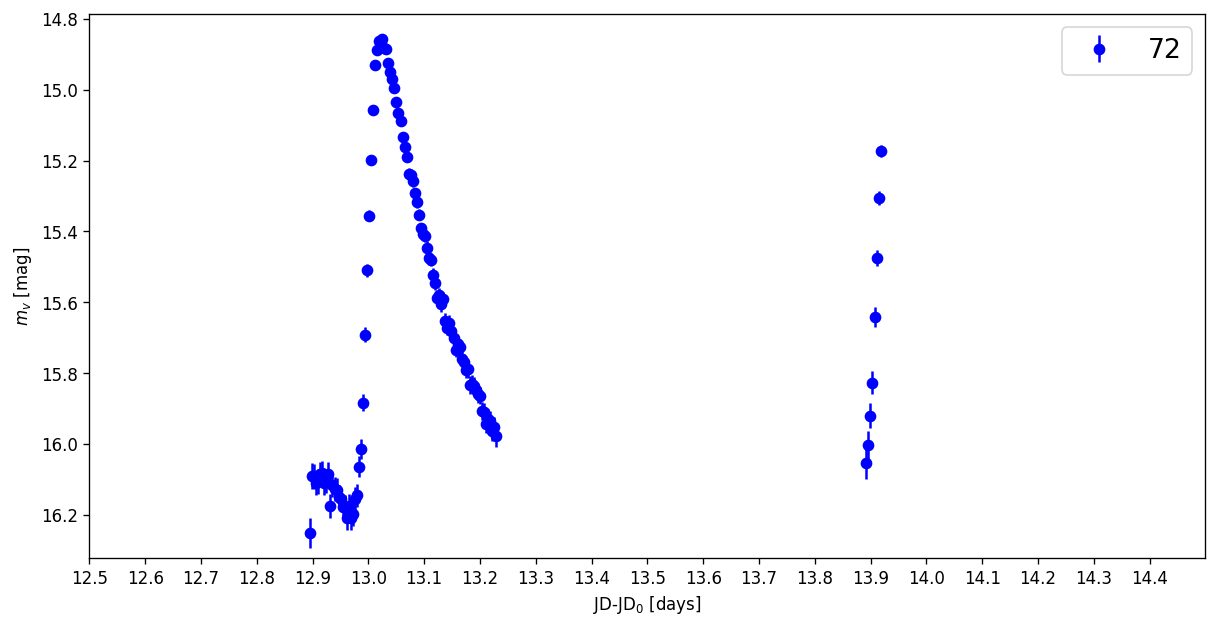

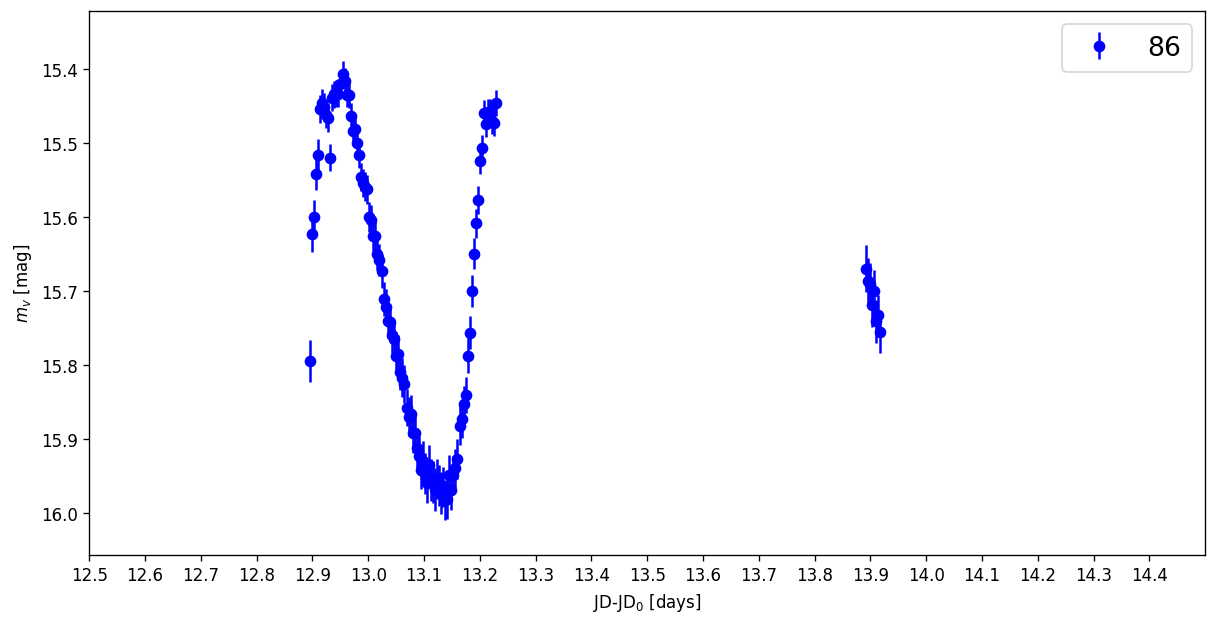

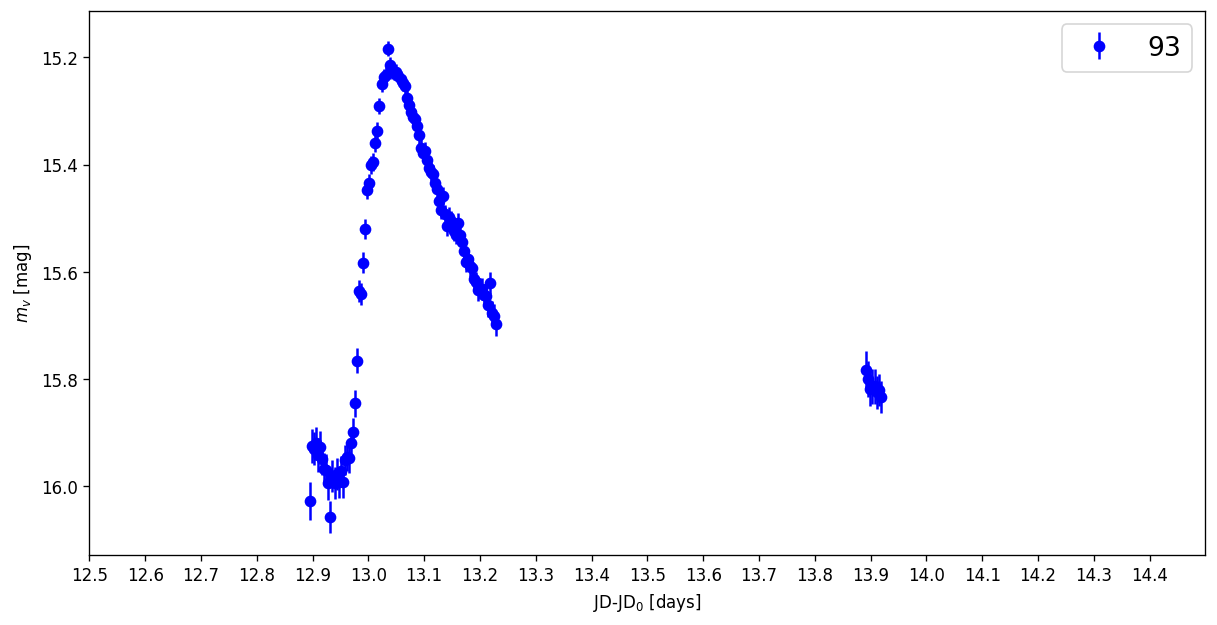

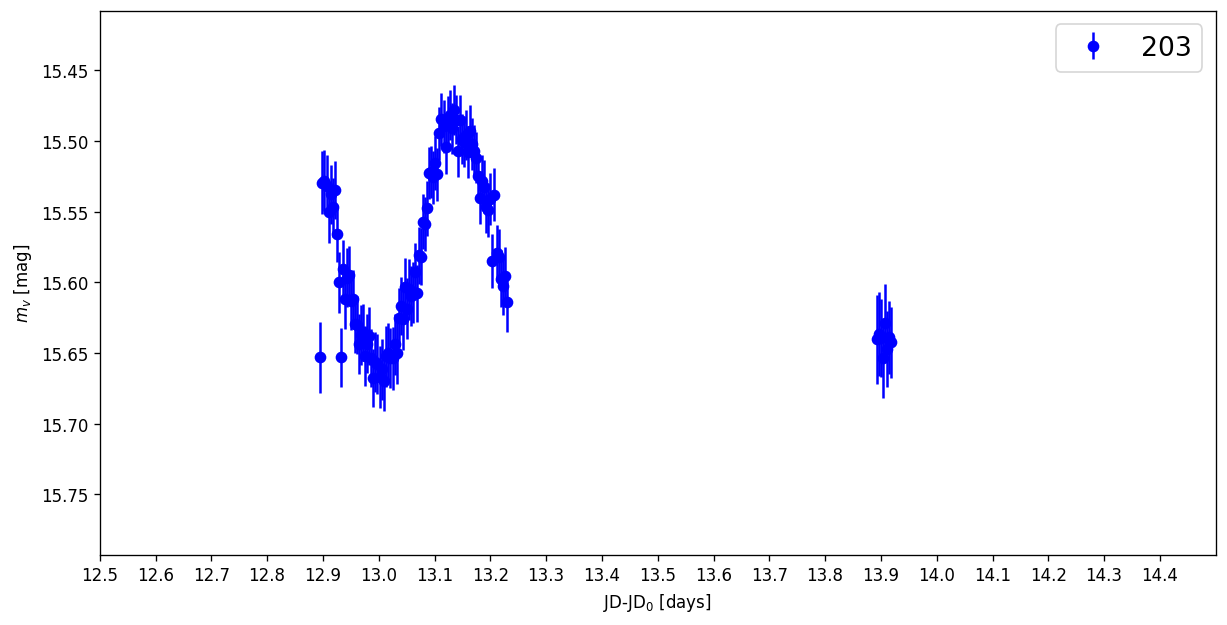

In [5]:
rr_lyr = np.genfromtxt('/home/3130_Shared_Data/Sp23/Lab4/rr_lyr.txt', dtype='str')
rr_lyr_name = rr_lyr[:, 0]
for i in range(4):
    vmin, vmax = np.max(phot_data['mag_app'][:, i]) + 0.07, np.min(phot_data['mag_app'][:, i]) - 0.07
    fig, ax = plt.subplots(figsize = (12,6), dpi = 120)
    ax.errorbar(phot_data['jd'] - phot_data['jd'][0], phot_data['mag_app'][:, i], fmt='bo', yerr=phot_data['mag_ins_err'][:, i], label=rr_lyr_name[i])
    #ax[0][0].errorbar(phot_data_new['jd'] - phot_data_new['jd'][0], phot_data_new['mag_app'][:, i], fmt='ro', yerr=phot_data_new['mag_ins_err'][:, i], label=rr_lyr_name[i])
    ax.legend(fontsize=16)
    ax.set_xlabel('JD-JD$_0$ [days]')
    ax.set_ylabel('$m_v$ [mag]')
    ax.set_ylim(vmin,vmax)
    
    #### USE THIS SECTION TO HELP GUESS THE PERIOD OF EACH RRL STAR ####
    ax.set_xlim(12.5,14.5) #Change this to zoom in on regions of the curve along the x axis
    start, end = ax.get_xlim()
    ax.xaxis.set_ticks(np.arange(start, end, 0.1))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    
    # Save the image
    #fig.savefig('./rr_lyr_lightcurve_' + rr_lyr_name[i] + '.pdf', bbox_inches='tight', pad_inches=0)

# Fold and plot the light curves based on your guess of the period

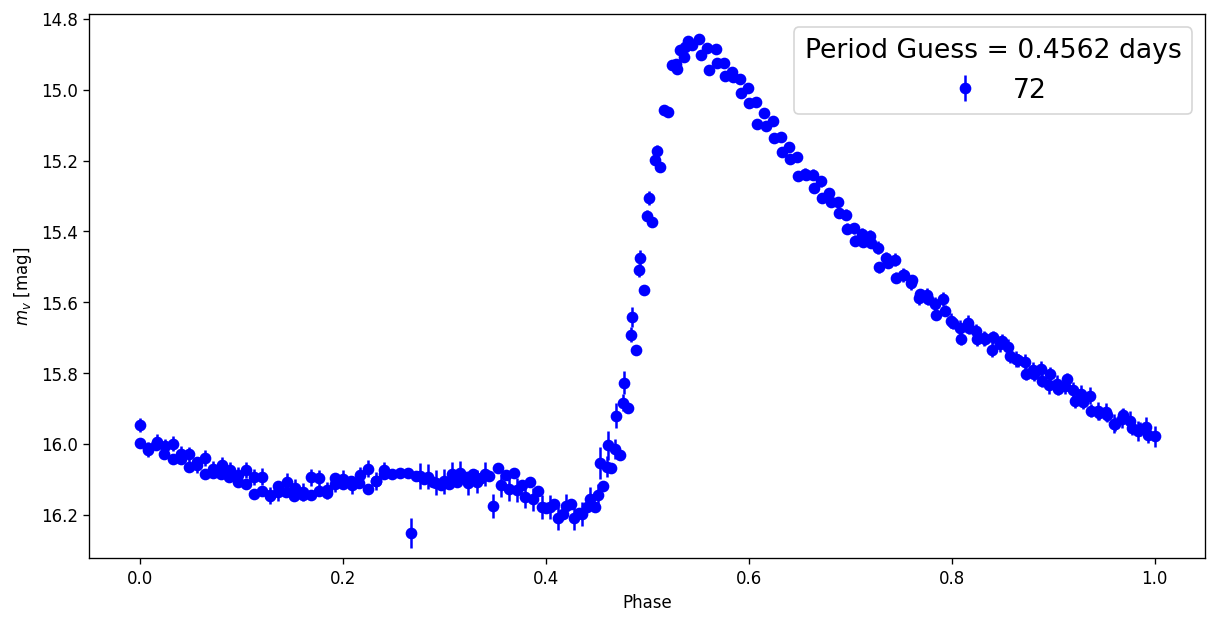

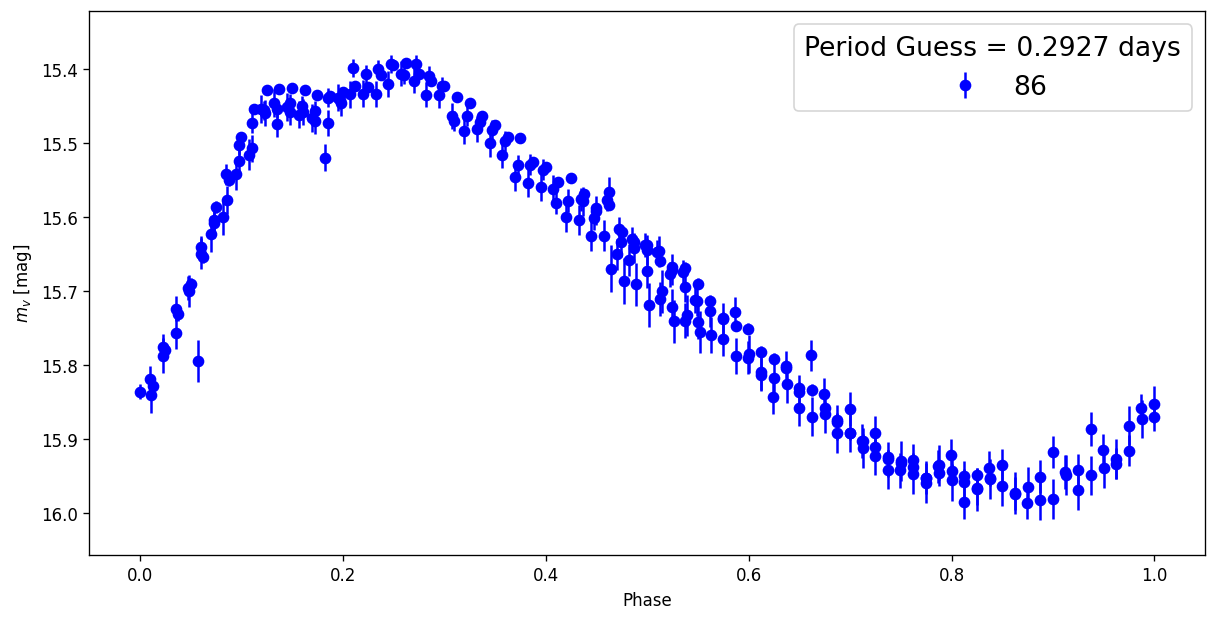

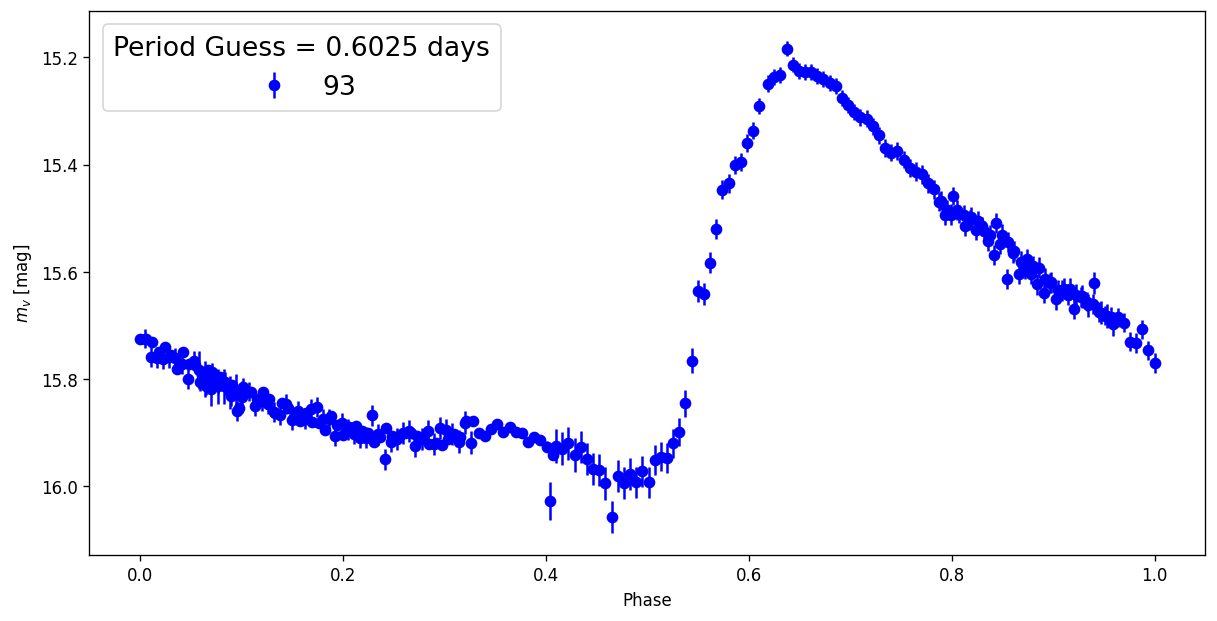

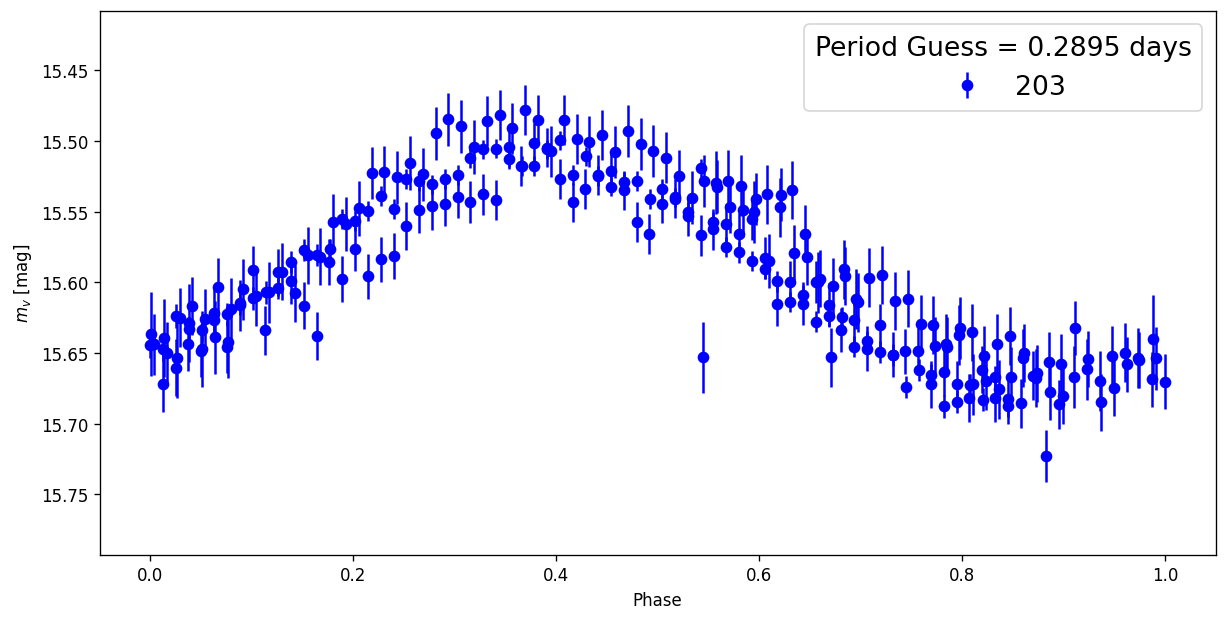

In [133]:
for i in range(4):
    # x data [days]
    x = phot_data['jd'] - phot_data['jd'][0]
    # y data [mags]
    y = phot_data['mag_app'][:,i]
    # y error data
    dy = (phot_data['mag_ins_err'][:, i]) #* u.mag
    
    
    # Guess the Period
    if i == 0:
        period = 0.4562 # 72
    elif i == 1:
        period = 0.2927 # 86
    elif i == 2:
        period = 0.6025 # 93
    else:
        period = 0.2895 # 203
    
    
    # Plot the folded light curves
    fig, ax = plt.subplots(figsize = (12,6), dpi = 120)
    
    vmin, vmax = np.max(y) + 0.07, np.min(y) - 0.07

    ax.errorbar(x % period / np.max(x%period), y, fmt='bo', yerr=dy, label=rr_lyr_name[i])

    ax.legend(title = 'Period Guess = %.4f days' % period, title_fontsize = 16, fontsize=16)
    ax.set_xlabel('Phase')
    ax.set_ylabel('$m_v$ [mag]')
    #ax.set_xlim(np.min(x%period)-0.1,np.max(x%period)+0.1)    
    #start, end = ax.get_xlim()
    #ax.xaxis.set_ticks(np.arange(start, end, 0.1))
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax.set_ylim(vmin,vmax)   
    
    #######################################################
    ### Uncomment the fig.savefig line to save your pix ###
    #######################################################
    fig.savefig('./curvy_folds_'+str(i)+'.pdf', bbox_inches='tight', pad_inches=0)

# Use astropy.timeseries.LombScargle to find the period of the 4 datasets and then fold the lightcurves

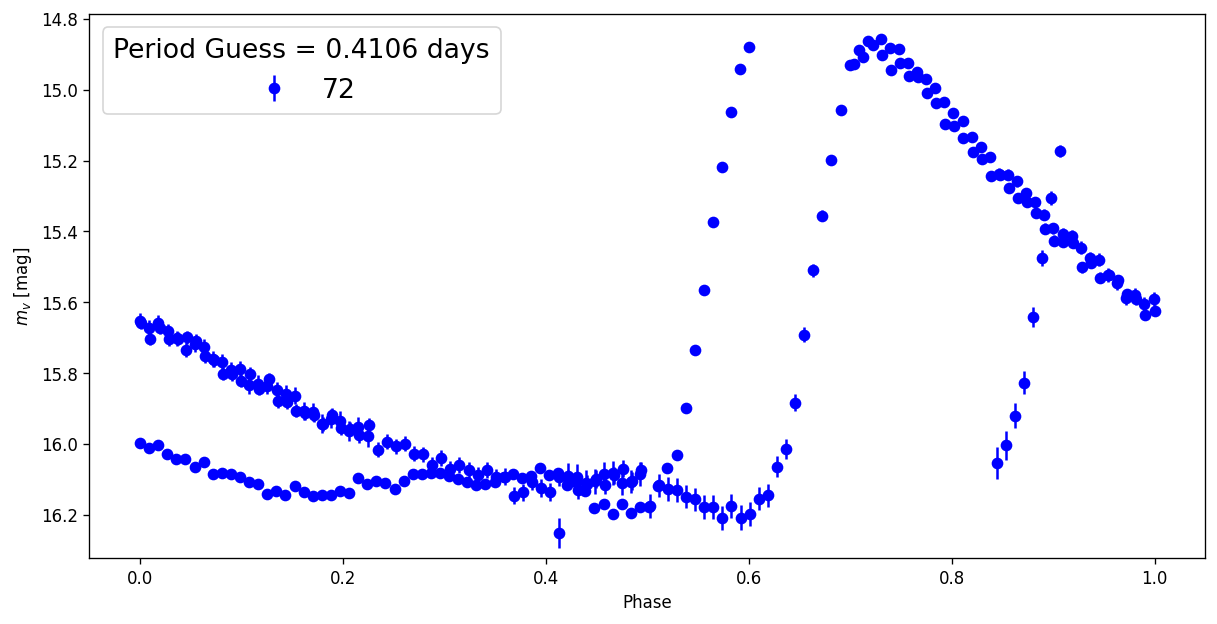

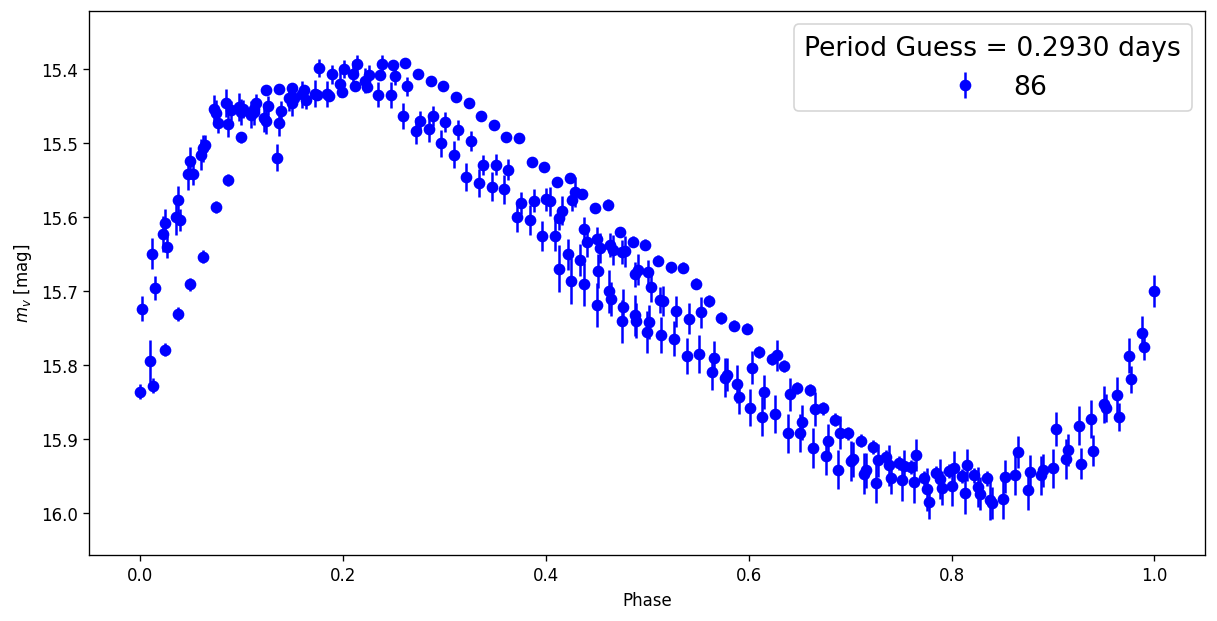

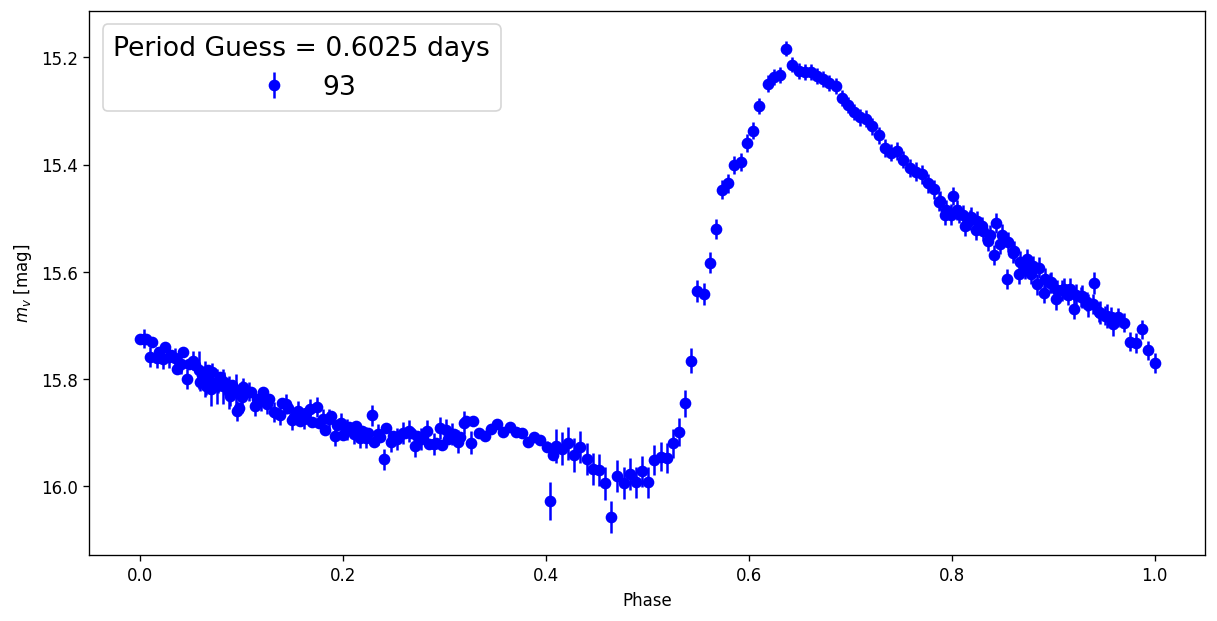

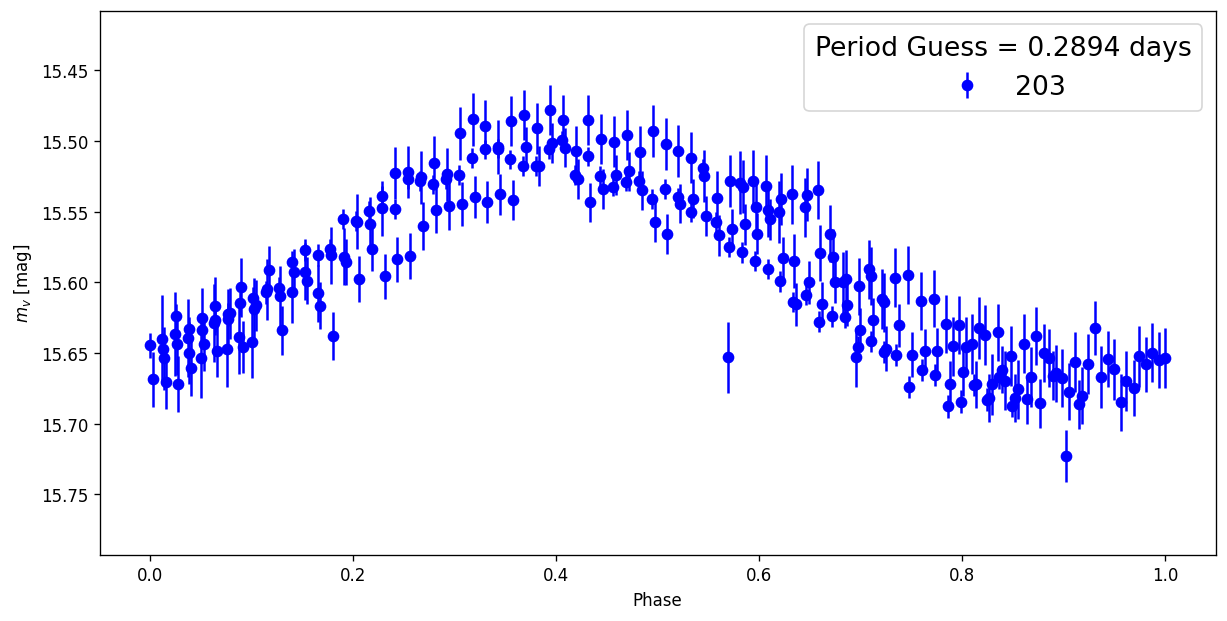

In [44]:
# Stack the lightcurves using the periods acquired via astropy.timeseries.LombScargle
for i in range(4):
    # x data [days]
    x = phot_data['jd'] - phot_data['jd'][0]
    # y data [mags]
    y = phot_data['mag_app'][:,i]
    # Optional: give units to x data
    xd = x #* u.day
    # Optional: give units to y data    
    ym = y #* u.mag
    # Optional: give units to y error data
    dy = (phot_data['mag_ins_err'][:, i]) #* u.mag
    # Compute the LombScargle (can find details here: https://docs.astropy.org/en/stable/timeseries/lombscargle.html)
    freq, p = LombScargle(xd,ym,dy).autopower()
    # define the Period 
    period = 1/freq[np.argmax(p)]
    
    
    # Plot the folded light curves
    fig, ax = plt.subplots(figsize = (12,6), dpi = 120)
    
    vmin, vmax = np.max(y) + 0.07, np.min(y) - 0.07

    ax.errorbar(x % period / np.max(x%period), y, fmt='bo', yerr=dy, label=rr_lyr_name[i])

    ax.legend(title = 'Period Guess = %.4f days' % period, title_fontsize = 16, fontsize=16)
    ax.set_xlabel('Phase')
    ax.set_ylabel('$m_v$ [mag]')
    #ax.set_xlim(np.min(x%period)-0.1,np.max(x%period)+0.1)    
    #start, end = ax.get_xlim()
    #ax.xaxis.set_ticks(np.arange(start, end, 0.1))
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    ax.set_ylim(vmin,vmax)   
    
    #######################################################
    ### Uncomment the fig.savefig line to save your pix ###
    #######################################################
    #fig.savefig('./curvy_folds_'+str(i)+'.pdf', bbox_inches='tight', pad_inches=0)

# L-S Diagram

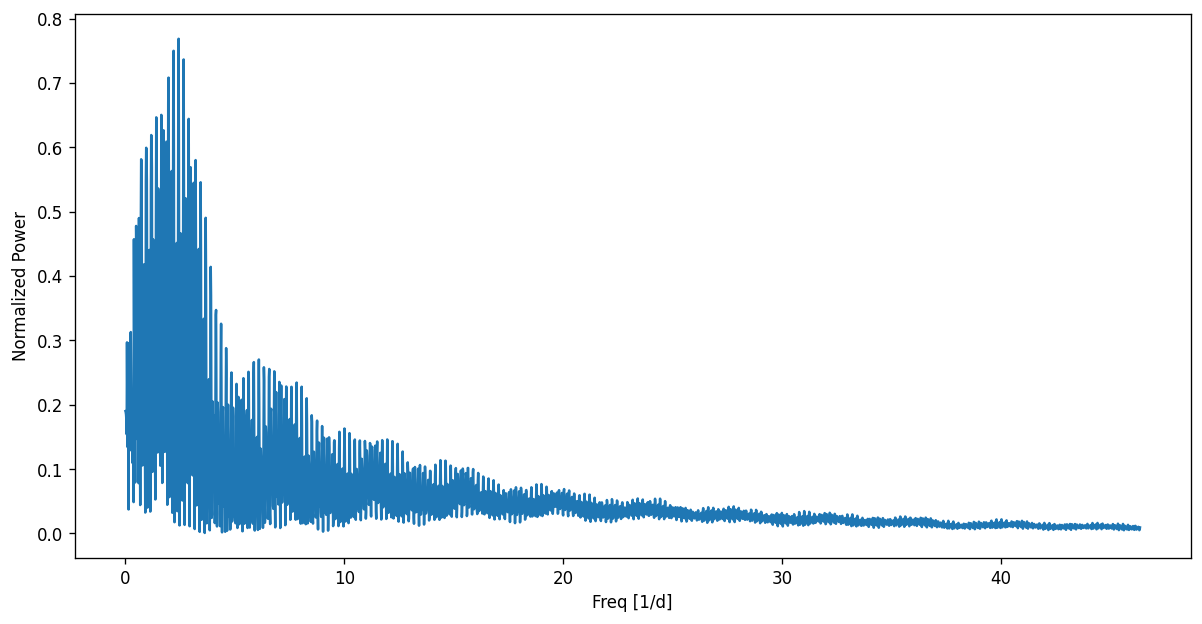

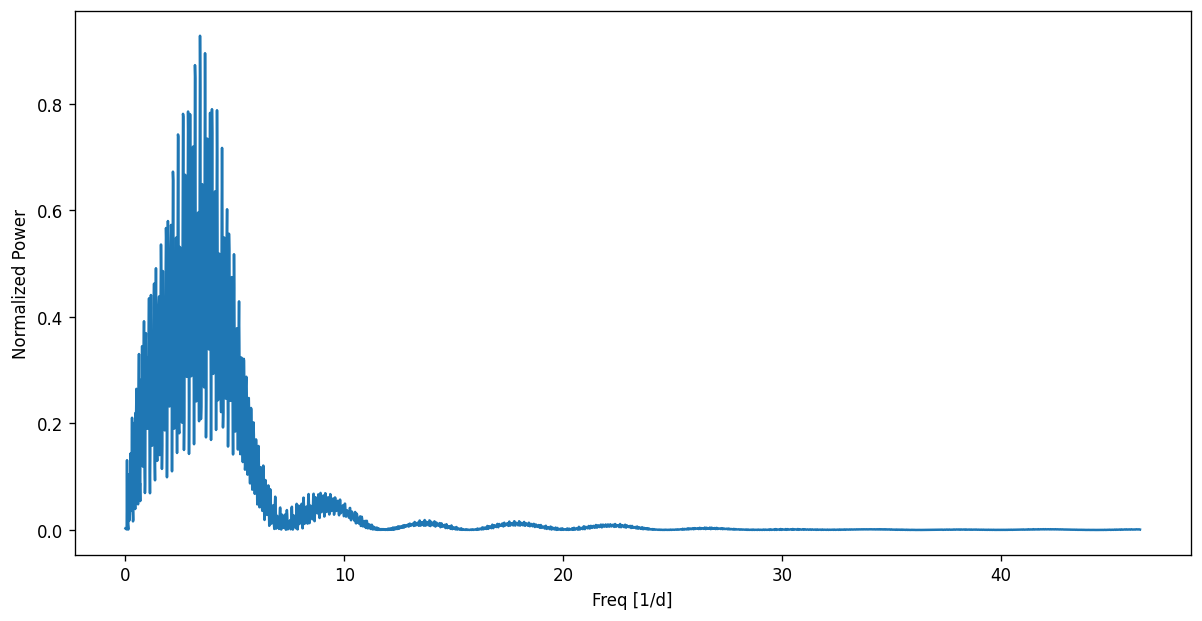

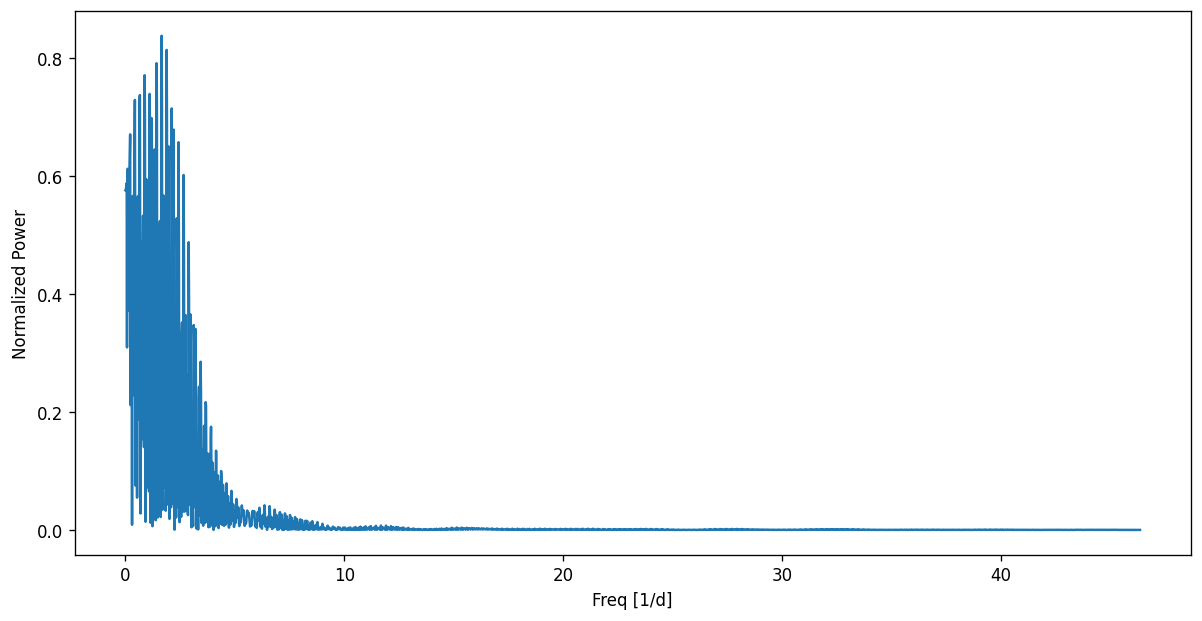

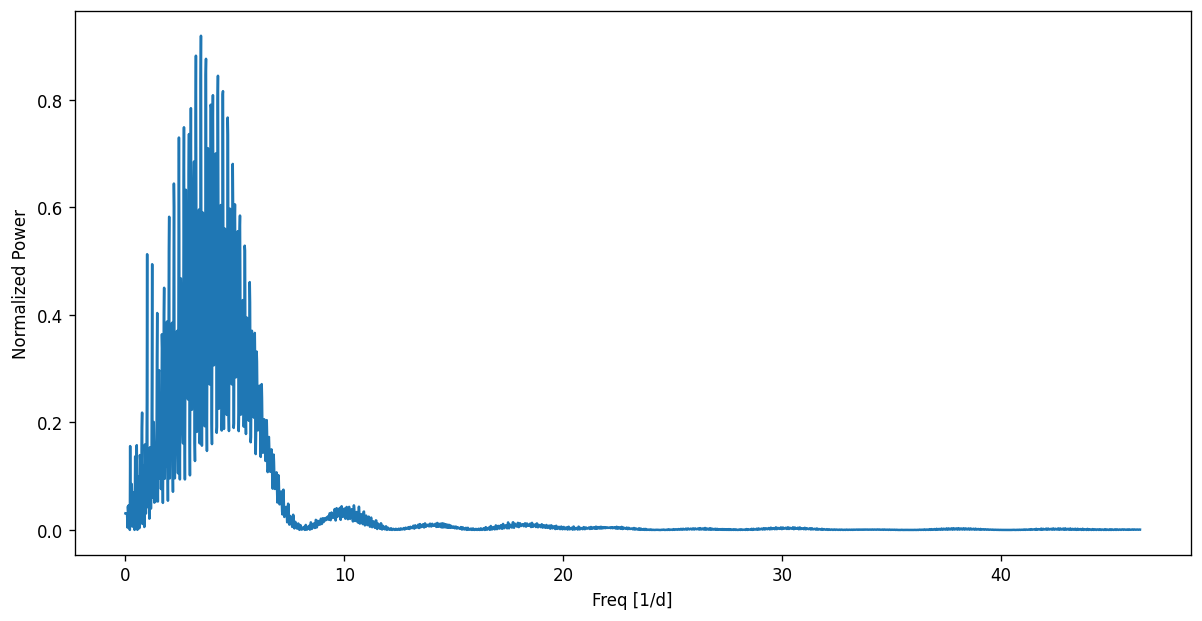

In [45]:
for i in range(4):
    # x data [days]
    x = phot_data['jd'] - phot_data['jd'][0]
    # y data [mags]
    y = phot_data['mag_app'][:,i]
    # Optional: give units to x data
    xd = x #* u.day
    # Optional: give units to y data    
    ym = y #* u.mag
    # Optional: give units to y error data
    dy = (phot_data['mag_ins_err'][:, i]) #* u.mag
    # Compute the LombScargle (can find details here: https://docs.astropy.org/en/stable/timeseries/lombscargle.html)
    freq, p = LombScargle(xd,ym,dy).autopower()
    # define the Period
    period = 1/freq[np.argmax(p)]
    
    # Plot the folded light curves
    fig, ax = plt.subplots(figsize = (12,6), dpi = 120)
    
    vmin, vmax = np.max(y) + 0.07, np.min(y) - 0.07

    ax.plot(freq,p)
    
    #ax.legend(title = 'Period Guess = %.4f days' % period, title_fontsize = 16, fontsize=16)
    ax.set_xlabel('Freq [1/d]')
    ax.set_ylabel('Normalized Power')
    #ax.set_xlim(np.min(x%period)-0.1,np.max(x%period)+0.1)    
    #start, end = ax.get_xlim()
    #ax.xaxis.set_ticks(np.arange(start, end, 0.1))
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    #ax.set_ylim(vmin,vmax)  